In [1]:
import pandas as pd
import numpy as np
import eda
import visualization as viz
import feature_engineering as fe
import process_data as pr
import modeling as md

from sklearn.model_selection import StratifiedKFold, cross_val_score
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

model_number = 'catboost_simpleimputer'

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_train.sample(3)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
11392,11392,C,85.40,material_7,material_8,5,8,13,5,3,...,11.242,16.644,15.804,10.415,13.433,13.999,15.045,17.866,676.238,0
7069,7069,B,57.81,material_5,material_5,8,8,10,9,11,...,NaN,17.882,19.733,12.653,14.709,15.721,15.535,17.012,718.784,0
13573,13573,C,113.02,material_7,material_8,5,8,9,11,2,...,11.428,15.042,19.853,9.719,16.581,16.709,17.086,18.133,684.088,0


In [3]:
# Drop the id columns
dropped_columns = ['id', 'product_code']

df_train_model = df_train.drop(dropped_columns, axis=1)
df_test_model = df_test.drop(dropped_columns, axis=1)

# Assign train and test for X and y
X_train = df_train_model.drop('failure', axis=1)
y_train = df_train_model['failure']

X_test = df_test_model.copy()

In [4]:
cat_features = ['attribute_0', 'attribute_1', 'attribute_2', 'attribute_3']
continous_features = [cat for cat in X_train.columns if cat not in cat_features]
numerical_features = X_train.select_dtypes(include=['int', 'float']).columns

In [ ]:
X_train['m_3_missing'] = X_train.measurement_3.isna()
X_train['m_5_missing'] = X_train.measurement_5.isna()

X_test['m_3_missing'] = X_test.measurement_3.isna()
X_test['m_5_missing'] = X_test.measurement_5.isna()

In [5]:
si = SimpleImputer(strategy='mean')
# Apply preprocessing to the training data
X_train_transformed = si.fit_transform(X_train[continous_features])
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train[continous_features].columns)
X_train = pd.concat([X_train[cat_features], X_train_transformed], axis=1)

X_test_transformed = si.transform(X_test[continous_features])
X_test_transformed = pd.DataFrame(X_test_transformed, columns=X_test[continous_features].columns)
X_test = pd.concat([X_test[cat_features], X_test_transformed], axis=1)

X_train.head()

,attribute_0,attribute_1,attribute_2,attribute_3,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,material_7,material_8,9,5,80.10,7.0,8.0,4.0,18.040,12.518,...,20.155,10.672,15.859,17.594000,15.193,15.029,16.048444,13.034,14.684,764.100
1,material_7,material_8,9,5,84.89,14.0,3.0,3.0,18.213,11.540,...,17.889,12.448,17.947,17.915000,11.755,14.732,15.425000,14.395,15.631,682.057
2,material_7,material_8,9,5,82.43,12.0,1.0,5.0,18.057,11.652,...,18.288,12.715,15.607,19.172085,13.798,16.711,18.631000,14.094,17.946,663.376
3,material_7,material_8,9,5,101.07,13.0,2.0,6.0,17.295,11.188,...,19.060,12.471,16.346,18.377000,10.020,15.250,15.562000,16.154,17.172,826.282
4,material_7,material_8,9,5,188.06,9.0,2.0,8.0,19.346,12.950,...,18.093,10.337,17.082,19.932000,12.428,16.182,12.760000,13.153,16.412,579.885


In [6]:
target = 'failure'

combined_df = pd.concat([X_train, X_test])
combined_df.sample(2)

,attribute_0,attribute_1,attribute_2,attribute_3,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
20100,material_7,material_5,9,5,222.58,5.0,7.0,4.0,15.835,12.077,...,19.027000,13.420,14.522,19.381,10.036,16.995,15.468,15.217,16.957,661.226
2375,material_7,material_8,9,5,108.12,14.0,8.0,7.0,18.219,11.212,...,19.024714,11.097,16.114,19.780,11.668,14.948,18.790,13.674,17.019,760.411


Learning rate set to 0.067421
0:	learn: 0.6674157	test: 0.6674494	best: 0.6674494 (0)	total: 209ms	remaining: 3m 28s
100:	learn: 0.4928584	test: 0.5111141	best: 0.5107942 (61)	total: 5.47s	remaining: 48.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5107942141
bestIteration = 61

Shrink model to first 62 iterations.
Learning rate set to 0.067421
0:	learn: 0.6674969	test: 0.6677354	best: 0.6677354 (0)	total: 53.5ms	remaining: 53.5s
100:	learn: 0.4927265	test: 0.5093883	best: 0.5093832 (51)	total: 5.27s	remaining: 46.9s
200:	learn: 0.4714500	test: 0.5115076	best: 0.5092696 (107)	total: 11.7s	remaining: 46.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5092695572
bestIteration = 107

Shrink model to first 108 iterations.
Learning rate set to 0.067421
0:	learn: 0.6672516	test: 0.6677274	best: 0.6677274 (0)	total: 70.3ms	remaining: 1m 10s
100:	learn: 0.4926941	test: 0.5120121	best: 0.5114593 (69)	total: 7.54s	remaining: 1m 7s
Stopped by over

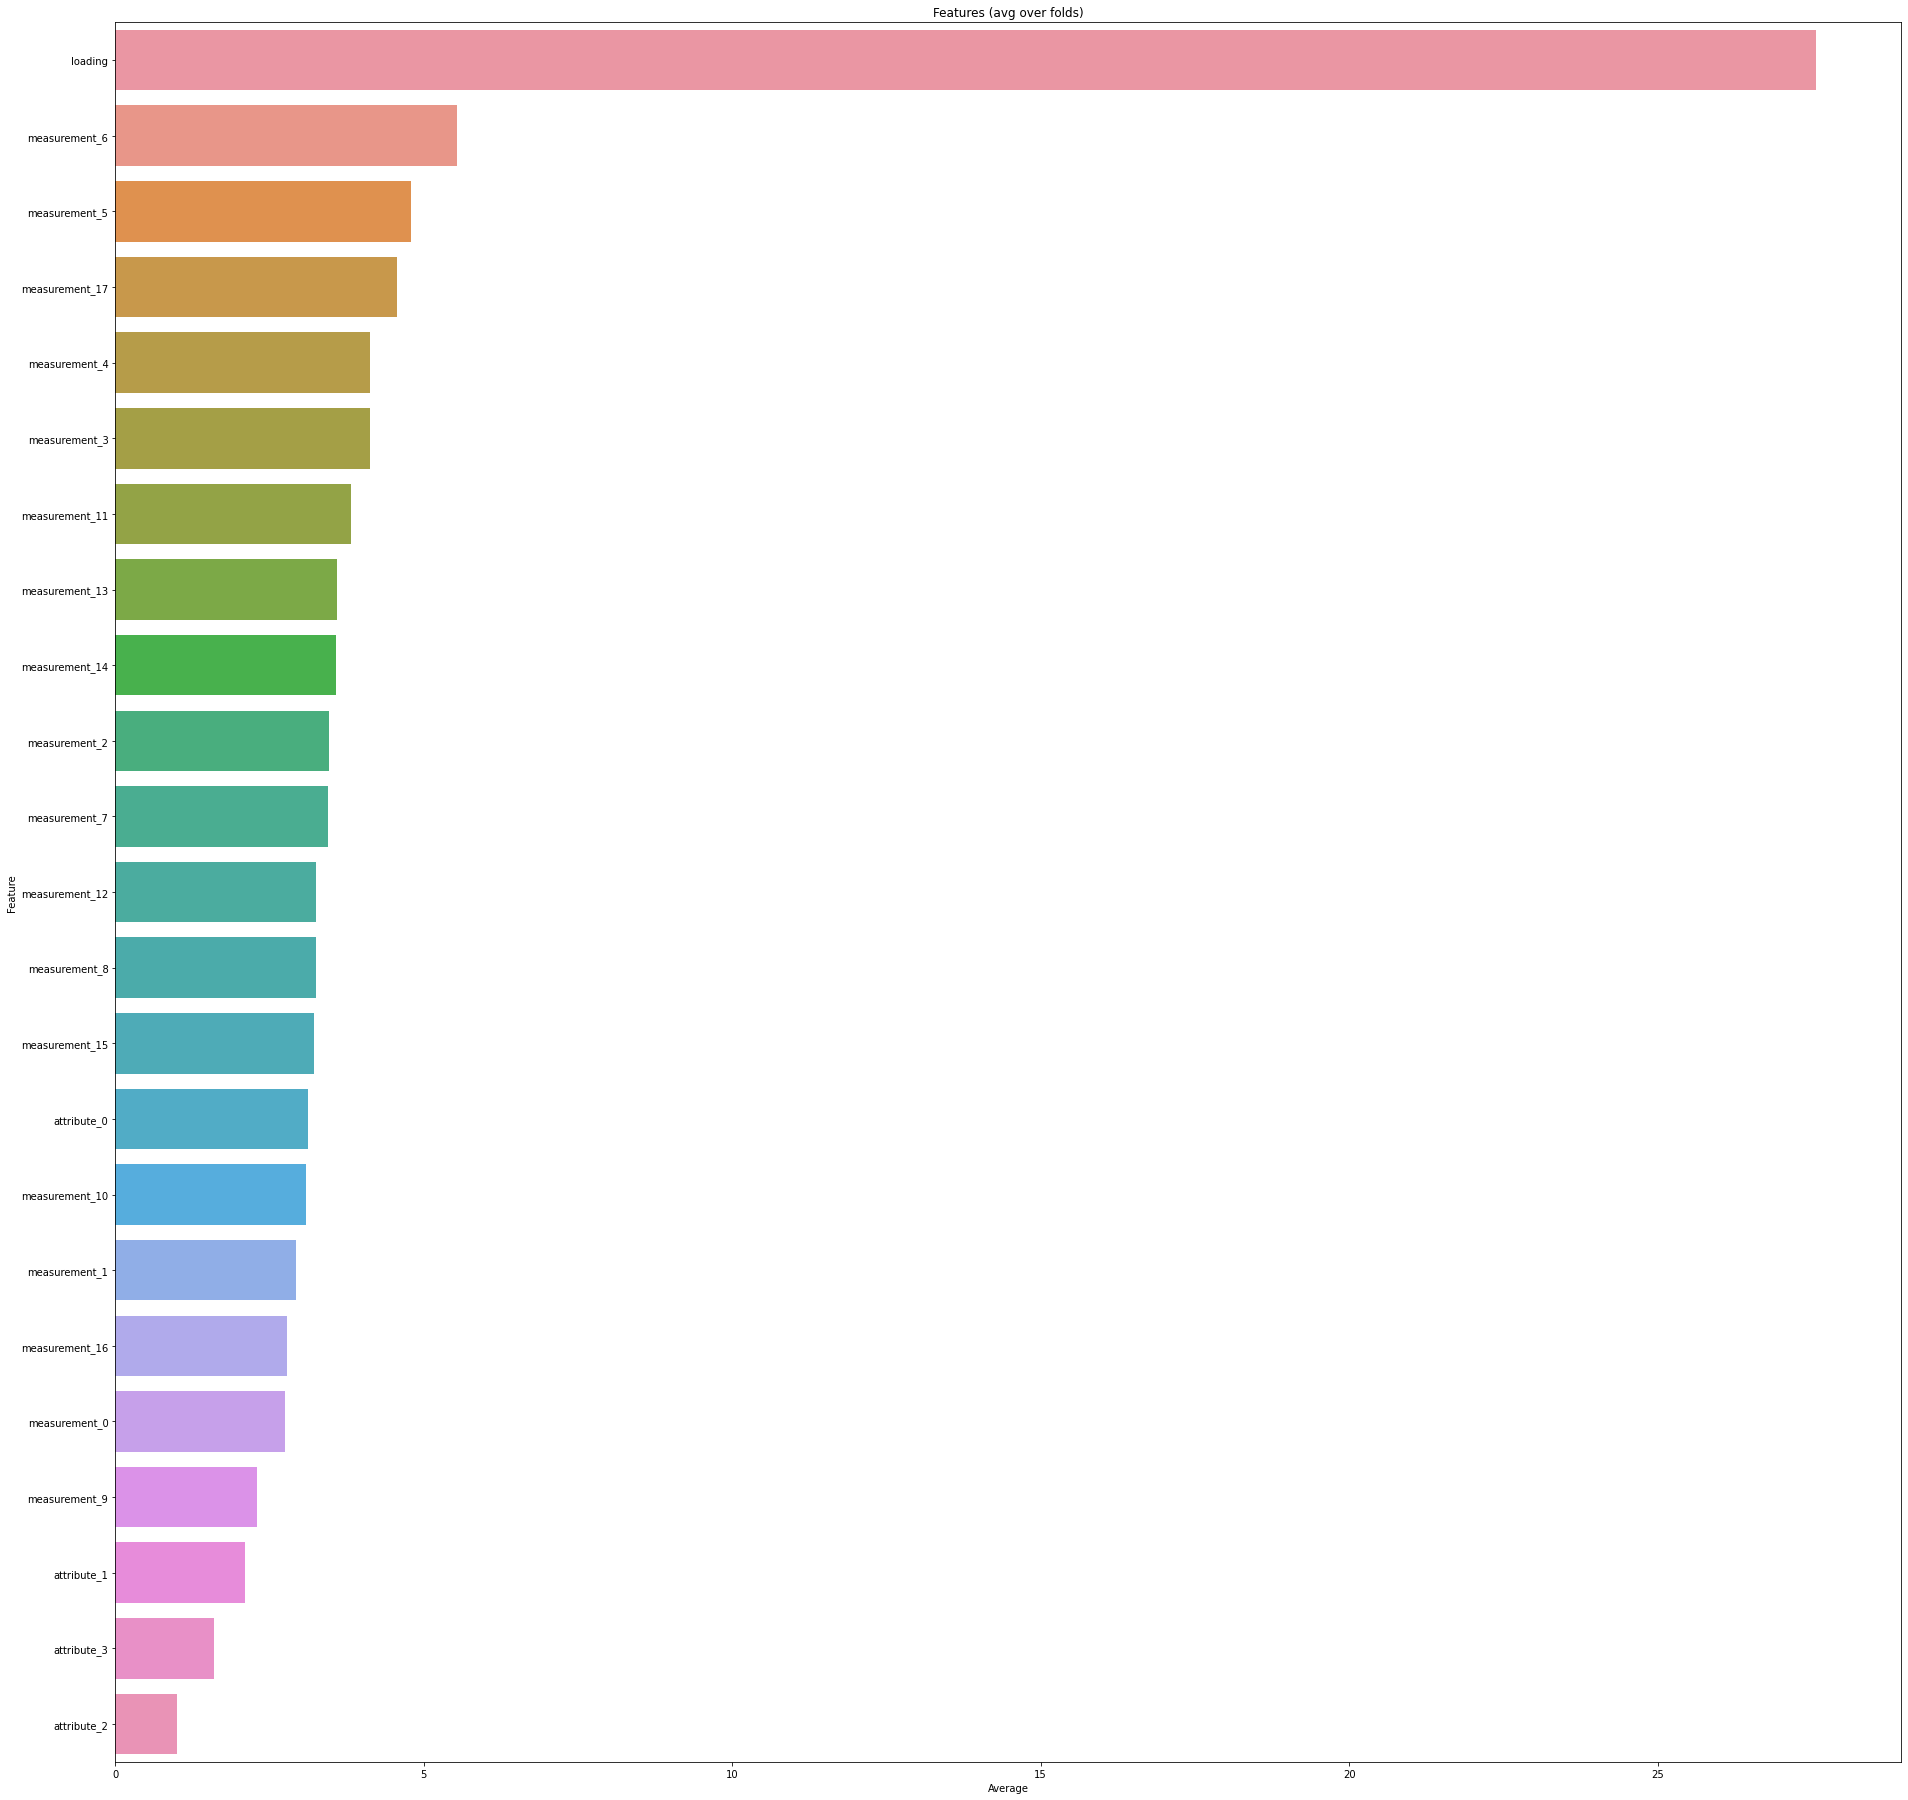

In [7]:
viz.plot_catboost_feature_importance(X_train, y_train, cat_features=cat_features, figsize=(32, 32))

In [8]:
# Create a blank DataFrame to store the results
result_df = pd.DataFrame({'Feature': X_train.columns})

# Calculate the mutual information scores 5 times
for i in range(5):
    mi_scores = fe.make_mi_scores_classification(X_train[numerical_features], y_train)
    result_df[f'Run_{i + 1}'] = mi_scores['MI Score']

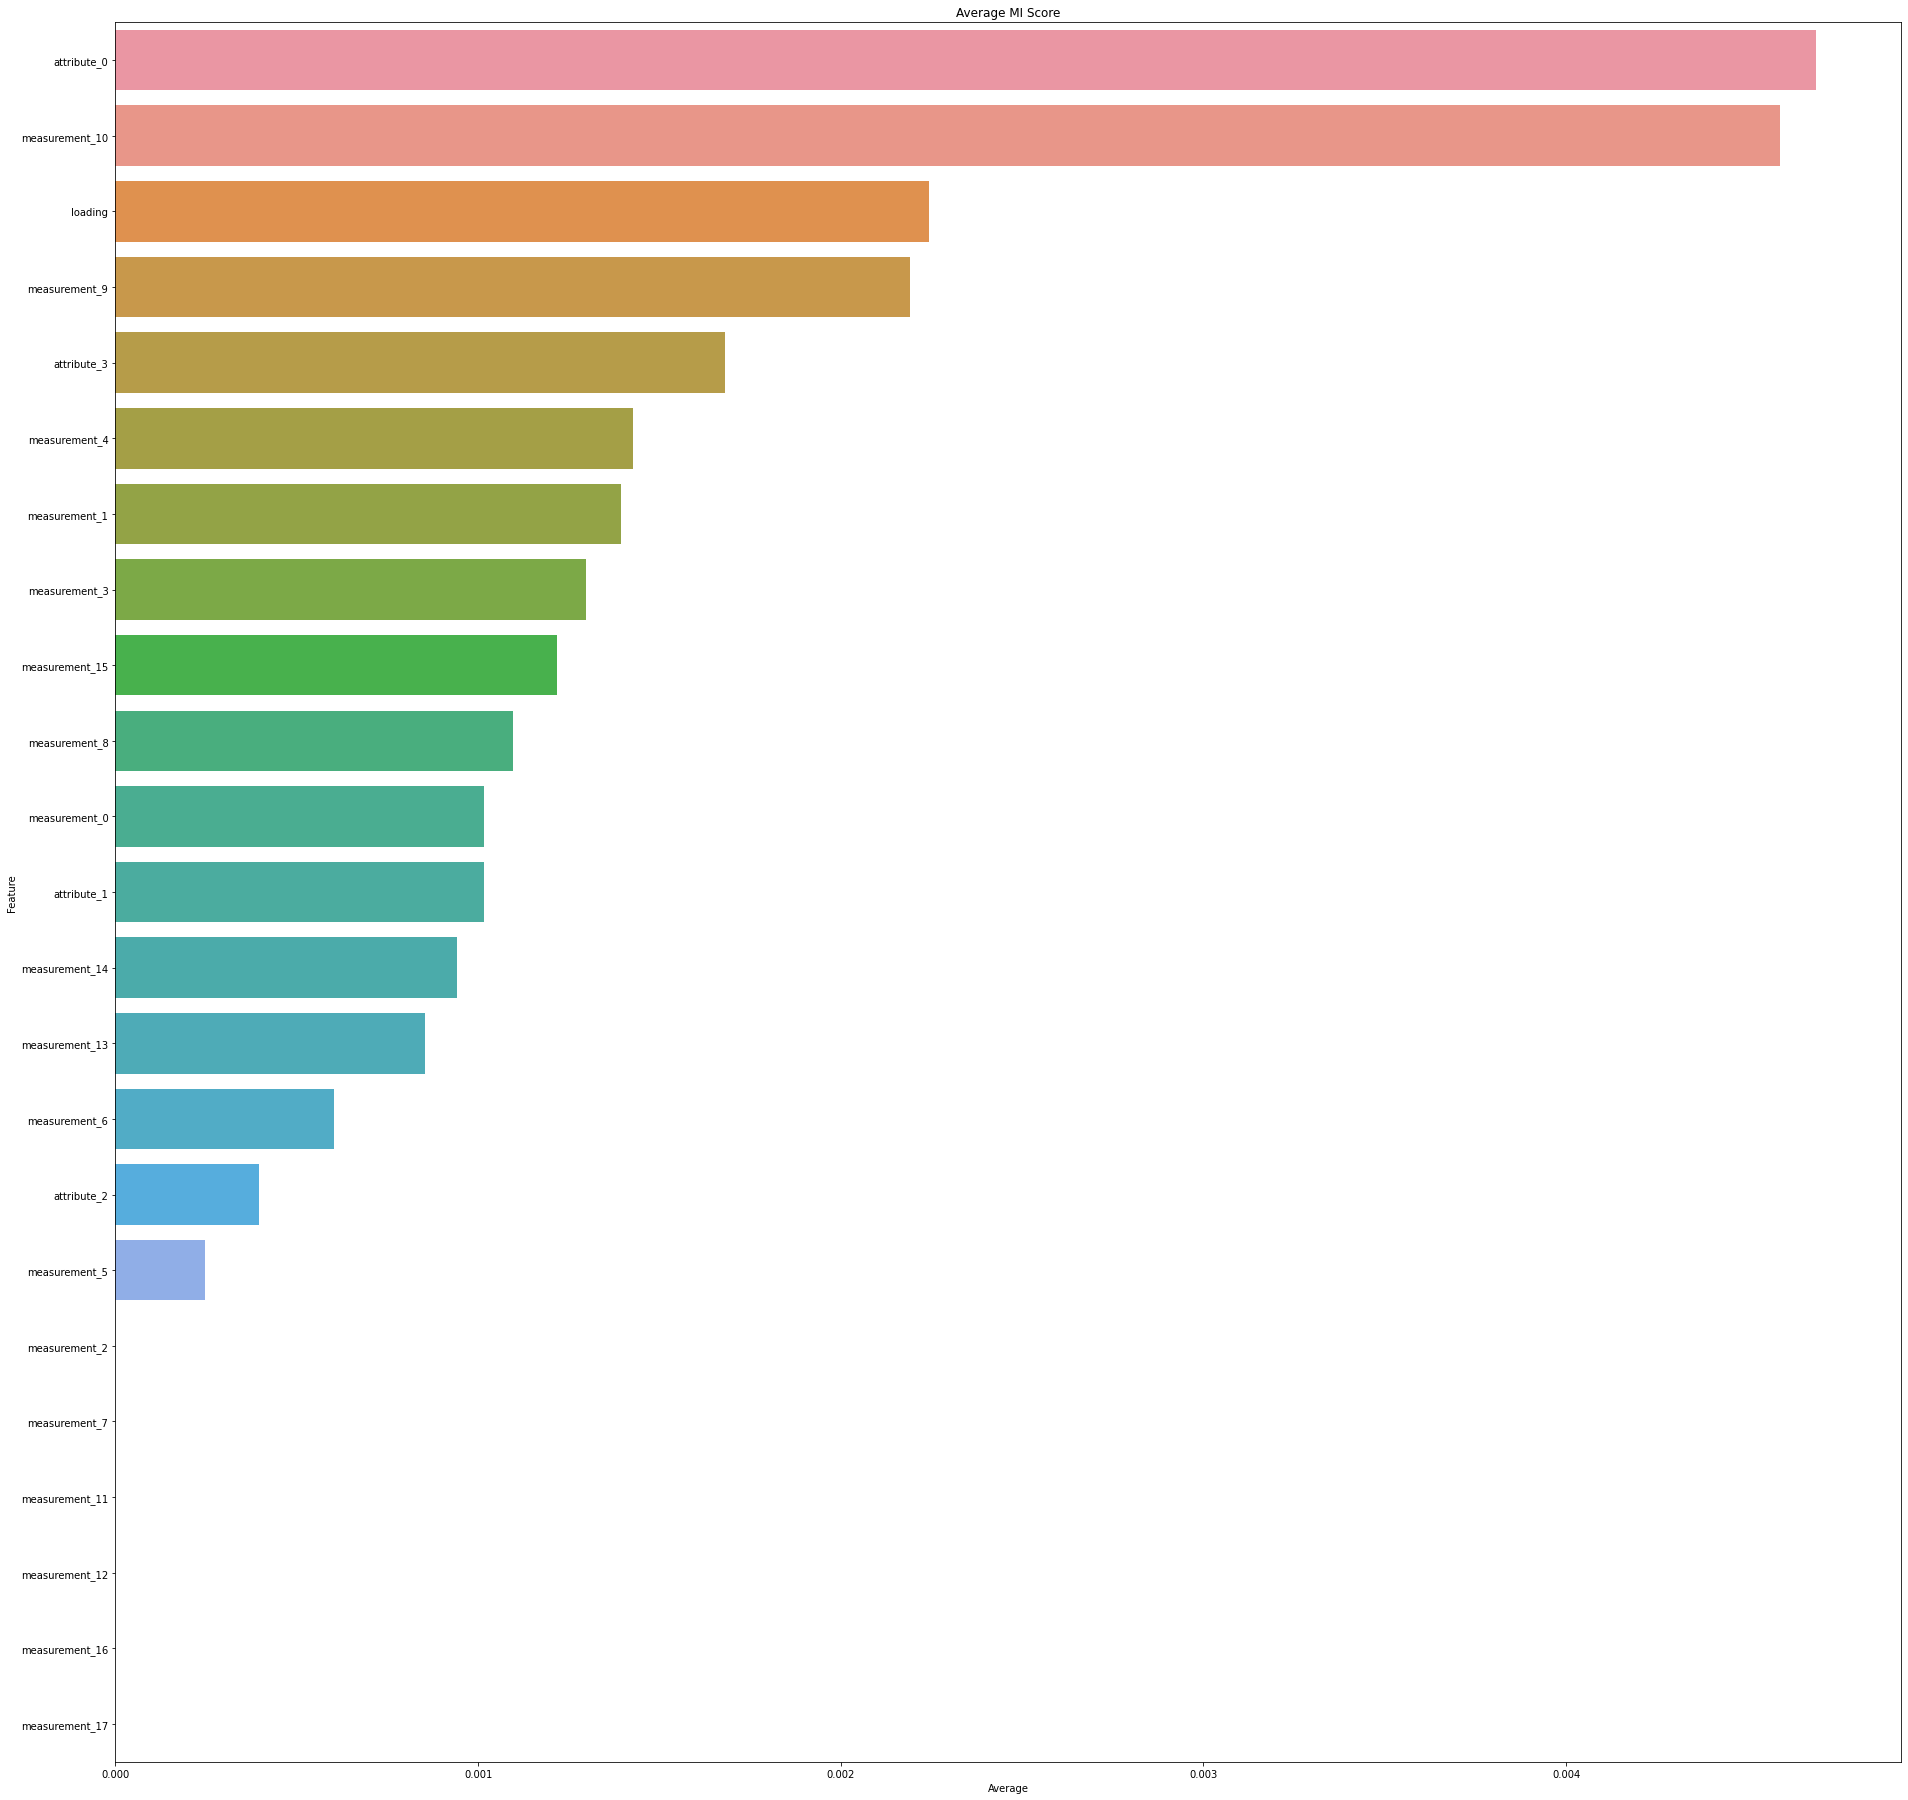

In [9]:
result_df['Average'] = result_df.iloc[:, 1:].mean(axis=1)
result_df = result_df.sort_values(by='Average', ascending=False)
result_df.to_csv(f'mi_result{model_number}.csv', index=False)

plt.figure(figsize=(32, 32))
sns.barplot(
    x=result_df['Average'],
    y=result_df['Feature'],
)

plt.title('Average MI Score')
plt.show()

In [22]:
more_dropped_columns = ['attribute_2', 'measurement_2', 'measurement_7', 'measurement_12', 'measurement_16']

model_number = 'catboost_simpleimputer_removed_cols_2'

In [23]:
# Initialize CatBoost model
# model = CatBoostClassifier(random_state=5, cat_features=['attribute_0', 'attribute_1','attribute_2', 'attribute_3'], verbose=False)
model = CatBoostClassifier(random_state=5, cat_features=['attribute_0', 'attribute_1', 'attribute_3'], verbose=False)

num_folds = 5
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=5)

# scores = cross_val_score(model, X_train.drop(dropped_columns_low_fi, axis=1), y_train, cv=cv, n_jobs=-1, scoring='roc_auc')
scores = cross_val_score(model, X_train.drop(more_dropped_columns, axis=1), y_train, cv=cv, n_jobs=-1, scoring='roc_auc')

list(scores), scores.mean(), scores.std()

([0.5625176592347083,
  0.5666950794429686,
  0.564494746103995,
  0.5629811841147904,
  0.5679319870048563],
 0.5649241311802637,
 0.0020944677833956635)

In [24]:
# Fit the model on the entire training data
# model.fit(X_train.drop(dropped_columns_low_fi, axis=1), y_train)
model.fit(X_train.drop(more_dropped_columns, axis=1), y_train)

# Predict on the X_test data
# predictions = model.predict_proba(X_test.drop(dropped_columns_low_fi, axis=1))[:, 1]
predictions = model.predict_proba(X_test.drop(more_dropped_columns, axis=1))[:, 1]

# Create a DataFrame for submission
submission_df = pd.DataFrame(
    {'id': df_test['id'],
    'failure': predictions})

# submission_df.head(50)
# Save to CSV for submission
submission_df.to_csv(f'submission_{model_number}.csv', index=False)